#  A/B-тестирование на пользователях приложения по доставке готовых продуктов

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
data_1 = pd.read_csv('/content/drive/MyDrive/5_task_1.csv')
data_2 = pd.read_csv('/content/drive/MyDrive/5_task_2.csv')

### 1) A/B тест - Разрешение фотографий блюд в приложении
Пользователям показывались либо прямоугольные, либо новые квадратные фотографии блюд

-	id – id клиента в эксперименте
-	group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

In [5]:
data_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [6]:
data_1.isna().sum()

,0
id,0
group,0
events,0


In [7]:
data_1 = data_1.fillna(0)

In [8]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.3+ KB


In [9]:
data_1.groupby('group').describe()

id                                                            \
         count        mean          std  min      25%      50%       75%   
group                                                                      
A      10000.0  14984.7227  8649.738079  0.0  7418.75  15049.5  22495.50   
B      10000.0  15009.0425  8677.230946  2.0  7551.75  14970.5  22528.25   
C      10000.0  15004.7348  8655.048204  1.0  7499.75  15000.5  22483.25   

                 events                                                   
           max    count     mean        std  min   25%   50%   75%   max  
group                                                                     
A      29997.0  10000.0  29.5796  10.079376 -6.0  23.0  30.0  36.0  63.0  
B      29998.0  10000.0  37.6136   9.848360  0.0  31.0  38.0  44.0  75.0  
C      29999.0  10000.0  27.4703   9.959048 -7.0  21.0  27.0  34.0  62.0

<ipython-input-10-1f28adb765d5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data_1, x = 'group', y = 'events', palette = 'viridis')


<Axes: xlabel='group', ylabel='events'>

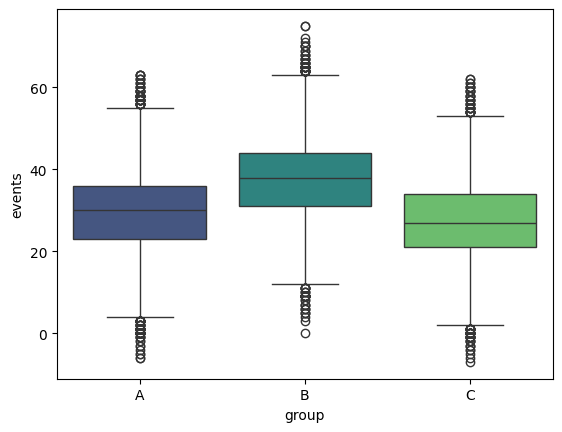

In [10]:
sns.boxplot(data = data_1, x = 'group', y = 'events', palette = 'viridis')

В данном случае имеется 3 варианта формата фотографий блюд, следовательно было бы уместно использовать многофакторный дисперсионный анализ, а также попарный Т-тест с поправкой Бонферрони

<ipython-input-11-2e8e4c6b9864>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_1[data_1['group'] == 'A']['events'], ax = axs[0], color = 'red')
<ipython-input-11-2e8e4c6b9864>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_1[data_1['group'] == 'B']['events'], ax = axs[1], color = '

<Axes: xlabel='events', ylabel='Density'>

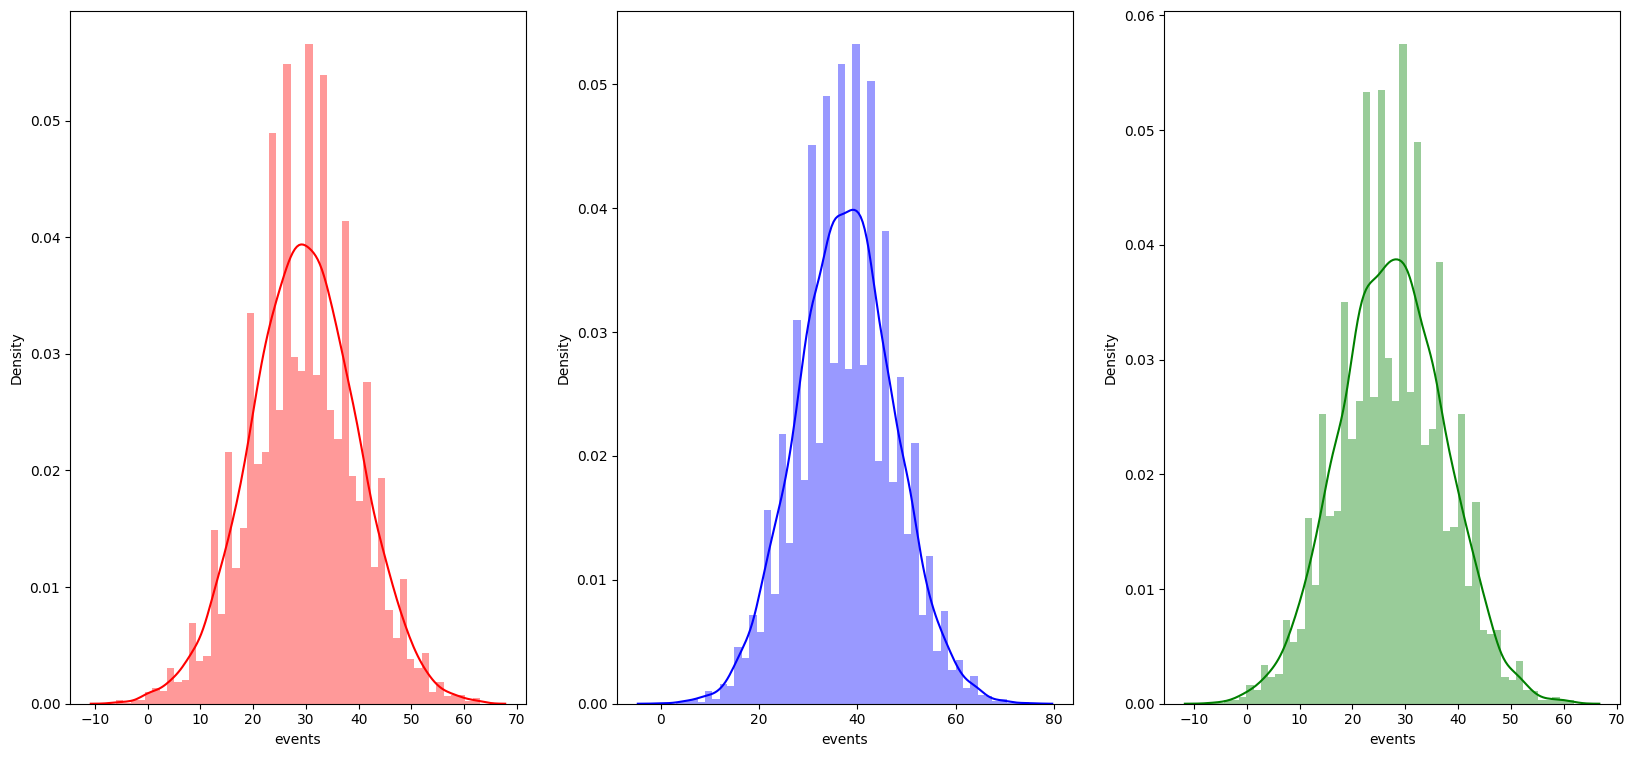

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (20, 9))

sns.distplot(data_1[data_1['group'] == 'A']['events'], ax = axs[0], color = 'red')
sns.distplot(data_1[data_1['group'] == 'B']['events'], ax = axs[1], color = 'blue')
sns.distplot(data_1[data_1['group'] == 'C']['events'], ax = axs[2], color = 'green')



#### 1.1) Проверим выборки на гомогенность дисперсий с помощью теста Левена

In [12]:
group_A = data_1[data_1['group'] == 'A']['events']
group_B = data_1[data_1['group'] == 'B']['events']
group_C = data_1[data_1['group'] == 'C']['events']

sps.levene(group_A, group_B, group_C)

LeveneResult(statistic=np.float64(2.2622596339318037), pvalue=np.float64(0.1041327199523974))

При уровне значимости 0.05 в данном случае у нас нет статистически значимых оснований для отвержения нулевой гипотезы о равенстве дисперсий. Следовательно, можно считать, что гомогенность дисперсий в трех выборках соблюдается

#### 1.2) Проверим выборки на нормальность распределения с помощью теста Шапиро-Уилка
Как мы уже успели оценить визуально, графики распределения всех трех рассматриваемых выборок прибизительно похожи на нормальные, но еще раз убедимся в этом, используя тест Шапиро-Уилка:

In [13]:
shapiro_A = sps.shapiro(group_A)
shapiro_B = sps.shapiro(group_B)
shapiro_C = sps.shapiro(group_C)


print('Shapiro test for group A: {}'.format(shapiro_A))
print('Shapiro test for group B: {}'.format(shapiro_B))
print('Shapiro test for group C: {}'.format(shapiro_C))

Shapiro test for group A: ShapiroResult(statistic=np.float64(0.9989209769788764), pvalue=np.float64(3.3827999572428407e-06))
Shapiro test for group B: ShapiroResult(statistic=np.float64(0.9990152741626567), pvalue=np.float64(1.0400249208438117e-05))
Shapiro test for group C: ShapiroResult(statistic=np.float64(0.9989340547219037), pvalue=np.float64(3.942400416472453e-06))


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


Тест Колмогорова-Смирнова (для уверенности):

In [21]:
print(sps.kstest(group_A, 'norm', args=(np.mean(group_A), np.std(group_A))))
print(sps.kstest(group_B, 'norm', args=(np.mean(group_B), np.std(group_B))))
print(sps.kstest(group_C, 'norm', args=(np.mean(group_C), np.std(group_C))))

KstestResult(statistic=np.float64(0.021631231092954117), pvalue=np.float64(0.00016990958697147846), statistic_location=np.int64(28), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.022802744772575267), pvalue=np.float64(5.993012962500842e-05), statistic_location=np.int64(43), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.024344730151486083), pvalue=np.float64(1.398253668153192e-05), statistic_location=np.int64(23), statistic_sign=np.int8(1))


Визуальная оценка все-таки подвела и с уровнем значимости 0.05 во всех группах отвергается нулевая гипотеза о нормальности распределения количества заказанных блюд.

В таком случае вместо ANOVA проведем непараметрический тест Крускала-Уоллиса

#### 1.3) Сравнение средних в выборках с помощью критерия Крускала-Уоллиса

In [14]:
sps.kruskal(group_A, group_B, group_C)

KruskalResult(statistic=np.float64(4809.092726398699), pvalue=np.float64(0.0))

Полученный p-value меньше уровня значимости 0.05, из чего можно сделать вывод, что у нас есть статистически значимые основания считать, что хотя бы одна группа отличается от остальных. Далее проведем попарные сравнения средних с помощью теста Манна-Уитни (с поправкой Бонферрони)

In [20]:
mann_wit_ab = sps.mannwhitneyu(group_A, group_B)
mann_wit_bc = sps.mannwhitneyu(group_B, group_C)
mann_wit_ac = sps.mannwhitneyu(group_A, group_C)

print("Тест Манна-Уитни для групп A и B: ", mann_wit_ab)
print("Тест Манна-Уитни для групп B и C: ", mann_wit_bc)
print("Тест Манна-Уитни для групп A и C: ", mann_wit_ac)

Тест Манна-Уитни для групп A и B:  MannwhitneyuResult(statistic=np.float64(28461104.5), pvalue=np.float64(0.0))
Тест Манна-Уитни для групп B и C:  MannwhitneyuResult(statistic=np.float64(76492047.0), pvalue=np.float64(0.0))
Тест Манна-Уитни для групп A и C:  MannwhitneyuResult(statistic=np.float64(55999796.0), pvalue=np.float64(6.1911397731274634e-49))


По полученным p-value можно сделать вывод о том, что все три группы статистически значимо отличаются между собой попарно

#### 1.4) Вывод: какой формат лучше всего использовать

Посмотрим еще раз на сравнение средних с помощью графика boxplot:

<ipython-input-22-1f28adb765d5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data_1, x = 'group', y = 'events', palette = 'viridis')


<Axes: xlabel='group', ylabel='events'>

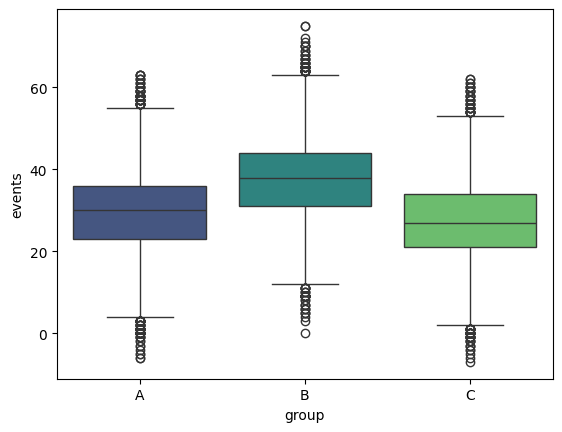

In [22]:
sns.boxplot(data = data_1, x = 'group', y = 'events', palette = 'viridis')

Как видно на графике, группа B значительно превосходит остальные две группы по количеству заказанных блюд, а из анализа статистической значимости этого отличия выше можно сделать вывод о том, что есть смысл использовать именно формат, предлагаемый группе B, то есть квадратный.

### 2) Обновление кнопки заказа
В приложении по доставке готовых продуктов была обновлена кнопка заказа

-	id – id клиента в эксперименте
-	segment – сегмент (high/low)
-	group – вид кнопки (control – старая версия, test – новая версия)
-	events – сколько блюд суммарно было заказано за период

In [24]:
data_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [25]:
data_2.isna().sum()

,0
id,0
group,0
segment,0
events,0


In [26]:
data_2.nunique()

,0
id,100000
group,2
segment,2
events,97


#### 2.1) В данном эксперименте было две группы, при этом стоит отметить, что тестировалась кнопка в двух сегментах. Есть смысл разделить всех юзеров на сегменты и по сегментам посмотреть изменения в показателе количества заказанных блюд. То есть в данном случае уместно будет использовать двухфакторный ANOVA

In [30]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [29]:
stat_mod = smf.ols(formula = "events ~ C(group)*C(segment)", data = data_2).fit()
anova_lm(stat_mod)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
C(segment),1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
C(group):C(segment),1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


По оценке p-value можно сказать, что с уровнем значимости 0.05 group (группа эксперимента) и segment (сегмент) значимо влияют на delivery_time по отдельности, а также прослеживается взаимодействие между факторами, что говорит о том, что эффект от новой кнопки также зависит и от сегмента.

#### 2.2) Построим графики тестовой и контрольной групп отдельно для каждого сегмента, а также их совместное распределение с разделением на тестовую и контрольную группы

<Axes: xlabel='events', ylabel='Count'>

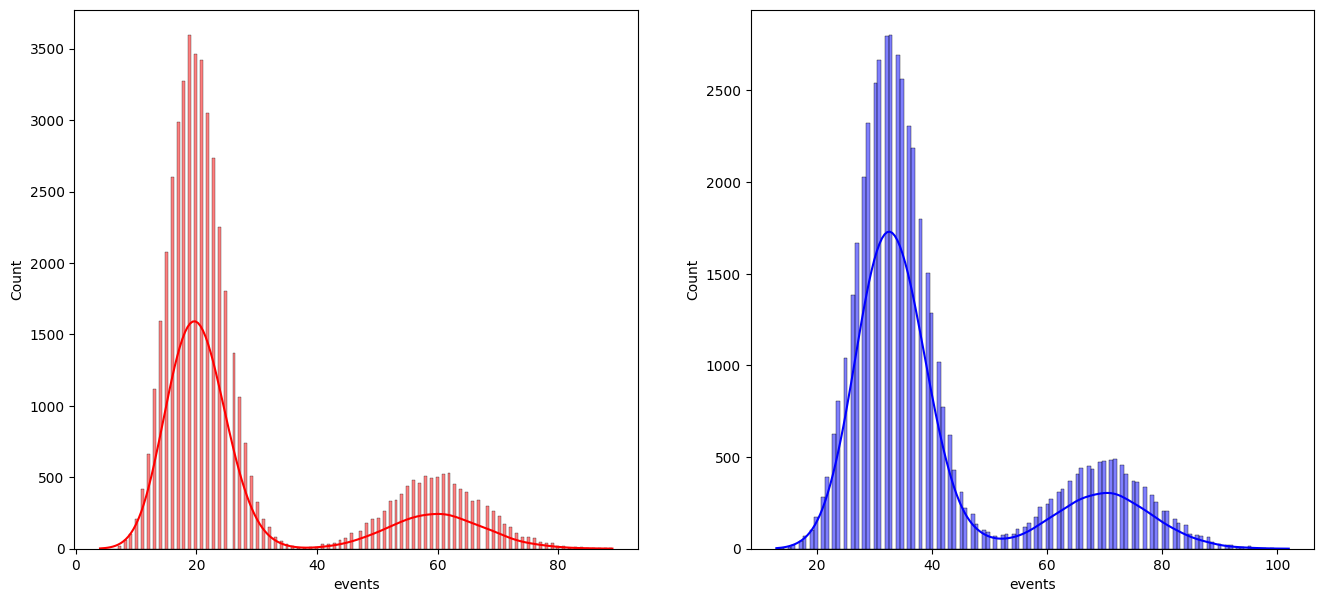

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (16, 7))

sns.histplot(data_2[data_2['group'] == 'control']['events'],
             color = 'red',
             ax = axs[0],
             kde = True)
sns.histplot(data_2[data_2['group'] == 'test']['events'],
             color = 'blue',
             ax = axs[1],
             kde = True)


Посмотрим на графики распределения отдельно для каждого сегмента:

Text(0.5, 1.0, 'Test Group - High Segment')

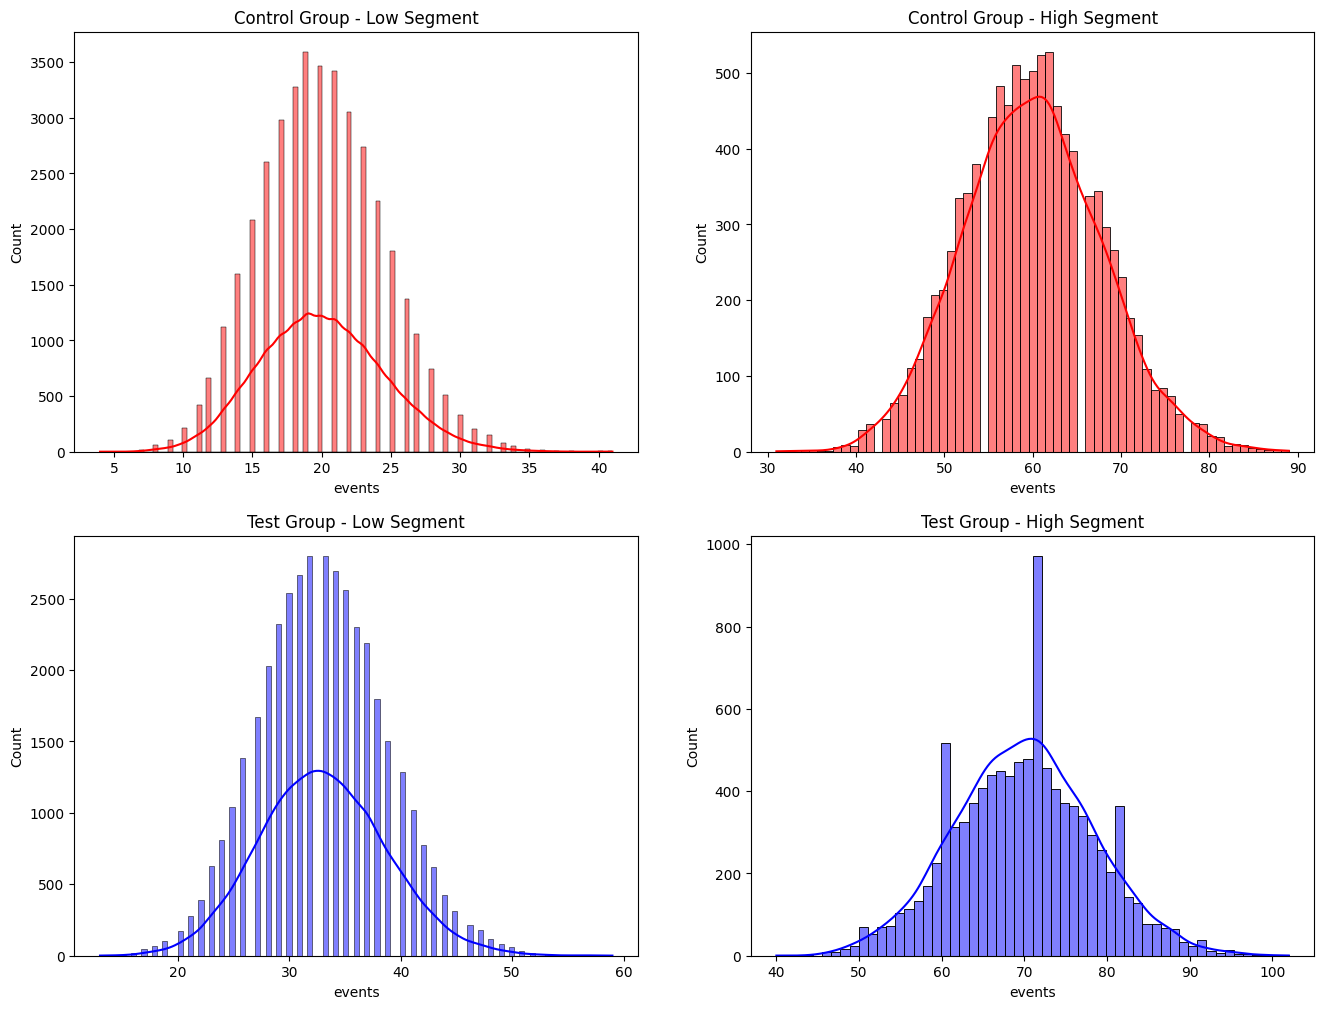

In [39]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

sns.histplot(data_2[(data_2['group'] == 'control')&(data_2['segment'] == 'low')]['events'],
             color = 'red',
             ax = axs[0][0],
             kde = True)
axs[0][0].set_title('Control Group - Low Segment')

sns.histplot(data_2[(data_2['group'] == 'control')&(data_2['segment'] == 'high')]['events'],
             color = 'red',
             ax = axs[0][1],
             kde = True)
axs[0][1].set_title('Control Group - High Segment')

sns.histplot(data_2[(data_2['group'] == 'test')&(data_2['segment'] == 'low')]['events'],
             color = 'blue',
             ax = axs[1][0],
             kde = True)
axs[1][0].set_title('Test Group - Low Segment')

sns.histplot(data_2[(data_2['group'] == 'test')&(data_2['segment'] == 'high')]['events'],
             color = 'blue',
             ax = axs[1][1],
             kde = True)
axs[1][1].set_title('Test Group - High Segment')



Описательные характеристики events по группе и по сегменту:

In [40]:
data_2.groupby(['group', 'segment']).describe()

id                                                     \
                   count        mean           std   min       25%      50%   
group   segment                                                               
control high     10000.0  50473.9782  28761.438914  10.0  25612.50  51031.0   
        low      40000.0  49935.2567  28855.849243   0.0  25022.25  49944.5   
test    high     10000.0  50126.6206  28821.133487  14.0  25317.50  50234.5   
        low      40000.0  49913.3436  28917.383492   1.0  24763.75  49706.5   

                                     events                                   \
                      75%      max    count       mean       std   min   25%   
group   segment                                                                
control high     75261.25  99976.0  10000.0  59.970800  7.805347  31.0  55.0   
        low      74874.25  99999.0  40000.0  20.031575  4.473576   4.0  17.0   
test    high     74783.25  99996.0  10000.0  69.938500  8.403974  40.0  64.0   
        low      75127.25  99995.0  40000.0  33.025925  5.720845  13.0  29.0   

                                    
                  50%   75%    max  
group   segment                     
control high     60.0  65.0   89.0  
        low      20.0  23.0   41.0  
test    high     70.0  76.0  102.0  
        low      33.0  37.0   59.0

Посмотрим на средние тестовой и контрольной выборок без разделения на сегменты:

<ipython-input-47-036867dd2f8e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data_2, x = 'group', y = 'events', palette='viridis')


<Axes: xlabel='group', ylabel='events'>

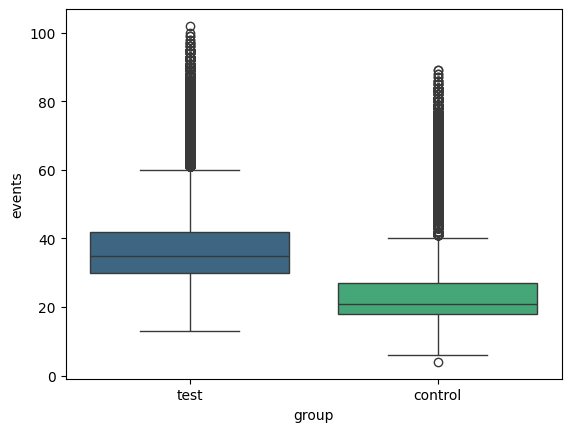

In [47]:
sns.boxplot(data = data_2, x = 'group', y = 'events', palette='viridis')

Вроде бы как среднее на тестовой выборке выше чем в контрольной, однако видно очень много выбросов, которые объясняются тем, что скорее всего в разных сегментах значительно различаются количественные показатели числа заказанныз блюд

Посмотрим на средние по группам отдельно для каждого сегмента:

<ipython-input-42-08916020241d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data_2[data_2['segment'] == 'low'], x = 'group', y = 'events', ax = axs[0], palette='viridis')
<ipython-input-42-08916020241d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data_2[data_2['segment'] == 'high'], x = 'group', y = 'events', ax = axs[1], palette='viridis')


Text(0.5, 1.0, 'High Segment')

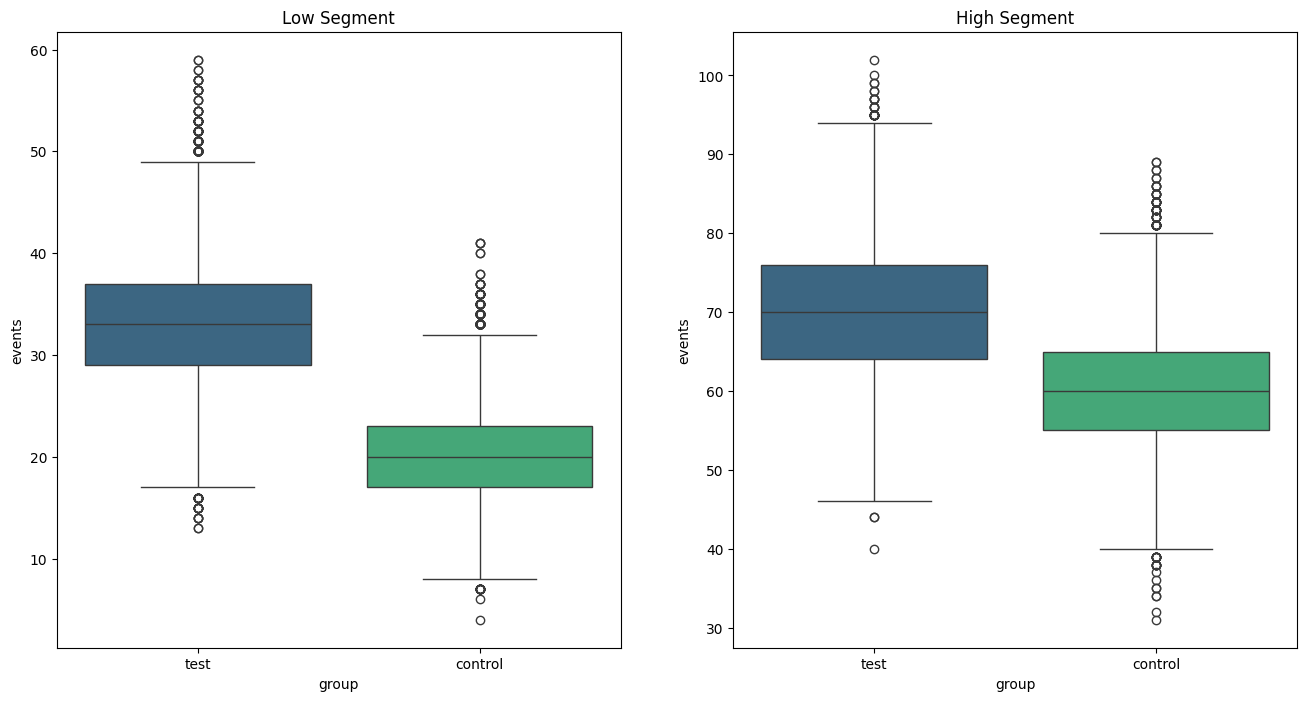

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (16, 8))

sns.boxplot(data = data_2[data_2['segment'] == 'low'], x = 'group', y = 'events', ax = axs[0], palette='viridis')
axs[0].set_title('Low Segment')
sns.boxplot(data = data_2[data_2['segment'] == 'high'], x = 'group', y = 'events', ax = axs[1], palette='viridis')
axs[1].set_title('High Segment')


Теперь выбросов не так много. На графике видно, что средние в обоих сегментах значительно выше в тестовых выборках, однако пока что нельзя сказать, статистически значим ли результат

#### 2.3) Проверим отдельно для каждого сегмента гомогенность дисперсий в тестовой и контрольной выборках с помощью теста Левена

In [50]:
low_test = data_2[(data_2['group'] == 'test')&(data_2['segment'] == 'low')]['events']
high_test = data_2[(data_2['group'] == 'test')&(data_2['segment'] == 'high')]['events']
low_control = data_2[(data_2['group'] == 'control')&(data_2['segment'] == 'low')]['events']
high_control = data_2[(data_2['group'] == 'control')&(data_2['segment'] == 'high')]['events']

print("Leven Test for low segment: ", sps.levene(low_test, low_control))
print("Leven Test for high segment: ", sps.levene(high_test, high_control))

Leven Test for low segment:  LeveneResult(statistic=np.float64(1985.5666465281558), pvalue=np.float64(0.0))
Leven Test for high segment:  LeveneResult(statistic=np.float64(46.92819248194447), pvalue=np.float64(7.577591733412336e-12))


При уровне значимости 0.05 в данном случае у нас есть статистически значимые основания для отвержения нулевой гипотезы о равенстве дисперсий для обоих сегментов. Следовательно, дисперсии статистически значимо отличаются для контрольной и тестовой выборок с разделениям по сегментам.

За одно проверим распределения на нормальность с помощью теста Шапиро-Уилка

In [54]:
shapiro_low_test = sps.shapiro(low_test)
shapiro_high_test = sps.shapiro(high_test)
shapiro_low_control = sps.shapiro(low_control)
shapiro_high_control = sps.shapiro(high_control)

shapiro = pd.DataFrame({'segment':['low', 'high', 'low', 'high'], 'group':['control', 'control', 'test', 'test'], 'pvalue':[shapiro_low_control.pvalue, shapiro_high_control.pvalue, shapiro_low_test.pvalue, shapiro_high_test.pvalue]})

shapiro

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40000.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


,segment,group,pvalue
0,low,control,3.575497e-39
1,high,control,1.264866e-11
2,low,test,2.125158e-31
3,high,test,5.464232e-09


При уровне значимости 0.05 в данном случае у нас есть статистически значимые основания для отвержения нулевой гипотезы о нормальности распределения для обоих сегментов и обоих выборок.

Во всех распределениях не выполняется два критерия: гомогенность дисперсий и нормальность распределений. Следовательно, воспользуемся непараметрическим тестом для оценки средних сначала отдельно для каждого сегмента с помощью теста Манна-Уитни:

In [61]:
u_stat_high, p_high = sps.mannwhitneyu(high_control, high_test, alternative="two-sided")
u_stat_low, p_low = sps.mannwhitneyu(low_control, low_test, alternative="two-sided")

print(f"Тест Манна-Уитни(High segment): U={u_stat_high}, p-value={p_high}")
print(f"Тест Манна-Уитни (Low segment): U={u_stat_low}, p-value={p_low}")

Тест Манна-Уитни(High segment): U=19239616.5, p-value=0.0
Тест Манна-Уитни (Low segment): U=57905269.0, p-value=0.0


In [60]:
kr_low = sps.kruskal(low_test, low_control)
kr_high = sps.kruskal(high_test, high_control)
kr = pd.DataFrame({'segment':['low', 'high'], 'pvalue':[kr_low.pvalue, kr_high.pvalue]})
kr

,segment,pvalue
0,low,0.0
1,high,0.0


При уровне значимости 0.05 в данном случае для обоих сегментов есть статистически значимые различия между test и control

Так как тест Манна-Уитни не учитывает взаимодействия факторов, воспользуемся бутстрепом:

##### Bootstrap:

In [66]:
def bootstrap_ci(data1, data2, n_bootstrap=10000, alpha=0.05):
    boot_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        boot_means.append(np.mean(sample2) - np.mean(sample1))  # Разница средних

    # 95% доверительный интервал
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))

    return lower, upper





In [67]:
ci_high = bootstrap_ci(high_control, high_test)
ci_low = bootstrap_ci(low_control, low_test)
print('High segment: ', ci_high)
print('Low segment: ', ci_low)

High segment:  (np.float64(9.743000000000002), np.float64(10.190005000000005))
Low segment:  (np.float64(12.924149374999997), np.float64(13.06357875))


По полученным доверительным интервалам видно, что 0 не входит в доверительный интервал, а также интервалы лежат значительно выше 0, что говорит о том, что смена кнопки действительно положительно повлияла на количество заказанных блюд в обоих сегментах

**Вывод:** Результаты A/B тестирования и оценки статистической значимости результатов, можно сказать, что новая кнопка повысила количество заказов и что ее следует запустить в прод, распространив на всех пользователей обоих сегментов